In [52]:
import re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

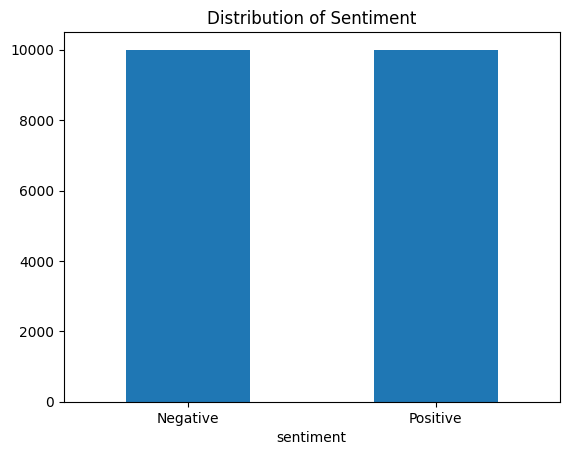

In [66]:
data_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
data_encoding = "ISO-8859-1"
data = pd.read_csv('Sample_data', encoding=data_encoding, names=data_columns)

data = data[['sentiment', 'text']]
data['sentiment'] = data['sentiment'].replace(4, 1)

ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of Sentiment', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

texts, sentiments = list(data['text']), list(data['sentiment'])


In [67]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']



In [68]:
def preprocess(textdata):
    processed_text = []

    word_lemmatizer = WordNetLemmatizer()

    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        tweet = re.sub(url_pattern, ' URL', tweet)

        for emoji in emojis.keys():
           tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        tweet = re.sub(user_pattern, ' USER', tweet)

        tweet = re.sub(alpha_pattern, " ", tweet)

        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        tweet_words = ''
        for word in tweet.split():
            if len(word) > 1:
                word = word_lemmatizer.lemmatize(word)
                tweet_words += (word + ' ')

        processed_text.append(tweet_words)

    return processed_text


In [69]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [97]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0.007553815841674805 seconds


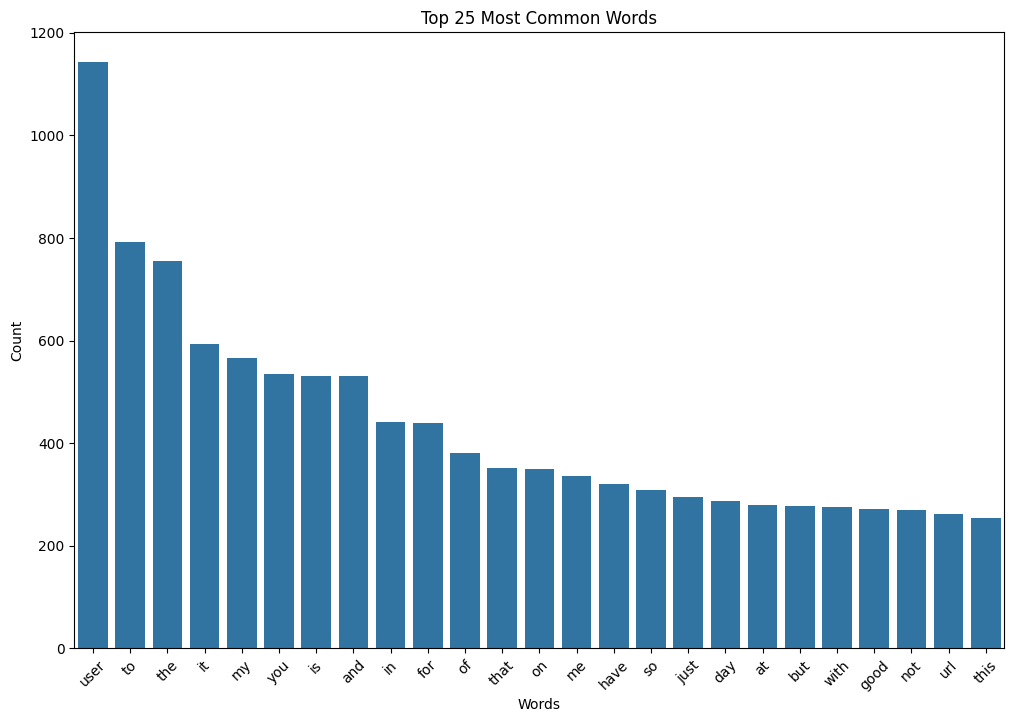

In [80]:
import numpy as np

X_train_vectorized = vectoriser.transform(processedtext)
feature_names = np.array(vectoriser.get_feature_names_out())
word_counts = np.array(X_train_vectorized.sum(axis=0))[0]

sorted_word_indices = np.argsort(word_counts)[::-1]
sorted_word_counts = word_counts[sorted_word_indices]
sorted_feature_names = feature_names[sorted_word_indices]

top_n = 25
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_names[:top_n], y=sorted_word_counts[:top_n])
plt.title(f'Top {top_n} Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


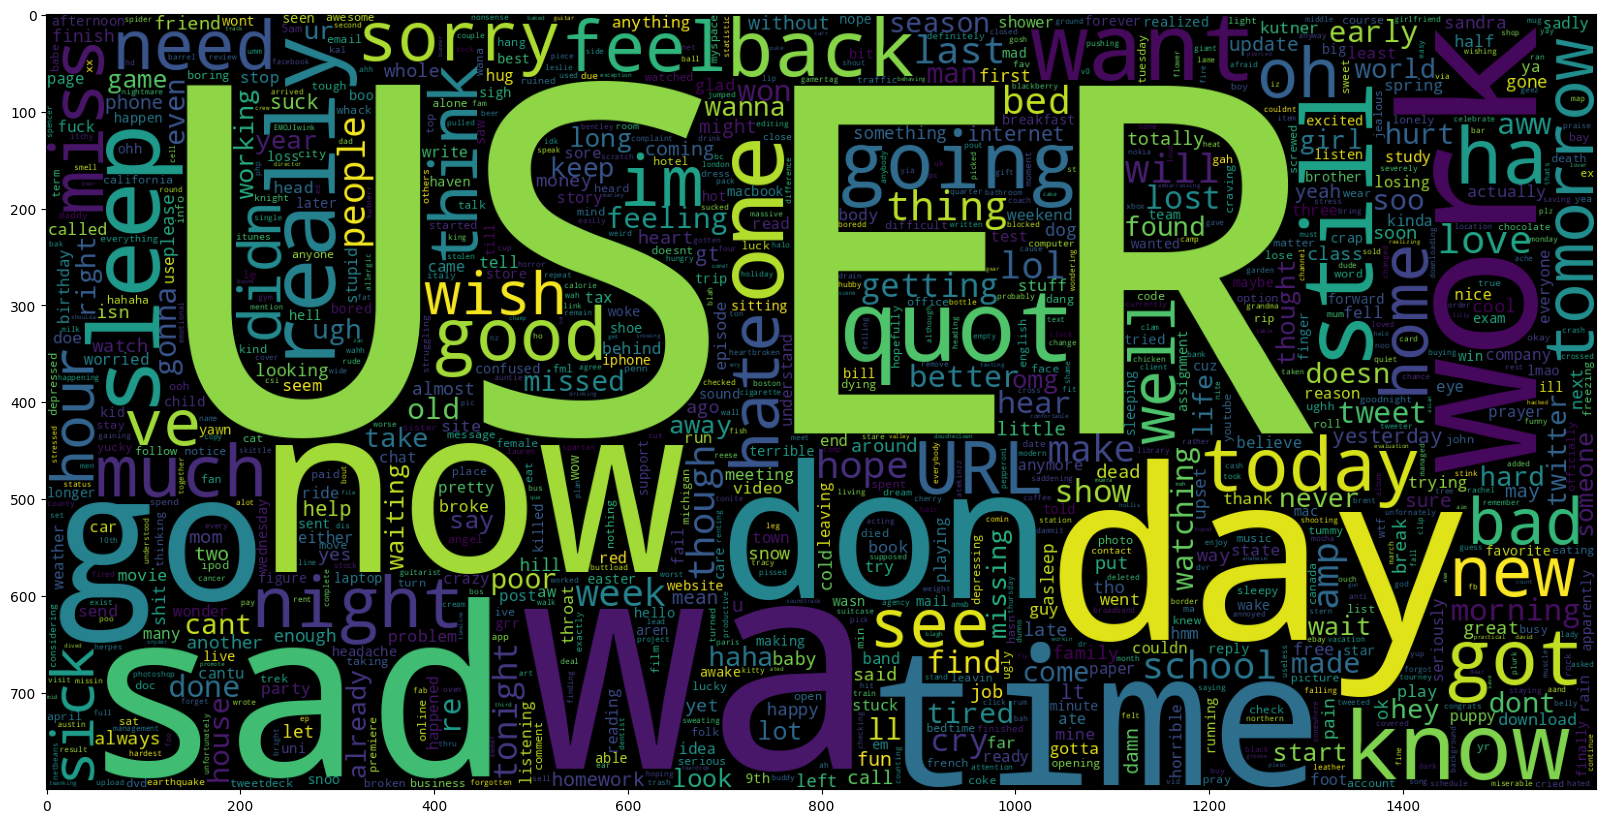

In [81]:
data_neg = processedtext[:1000]
plt.figure(figsize=(20, 20))
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wordcloud)


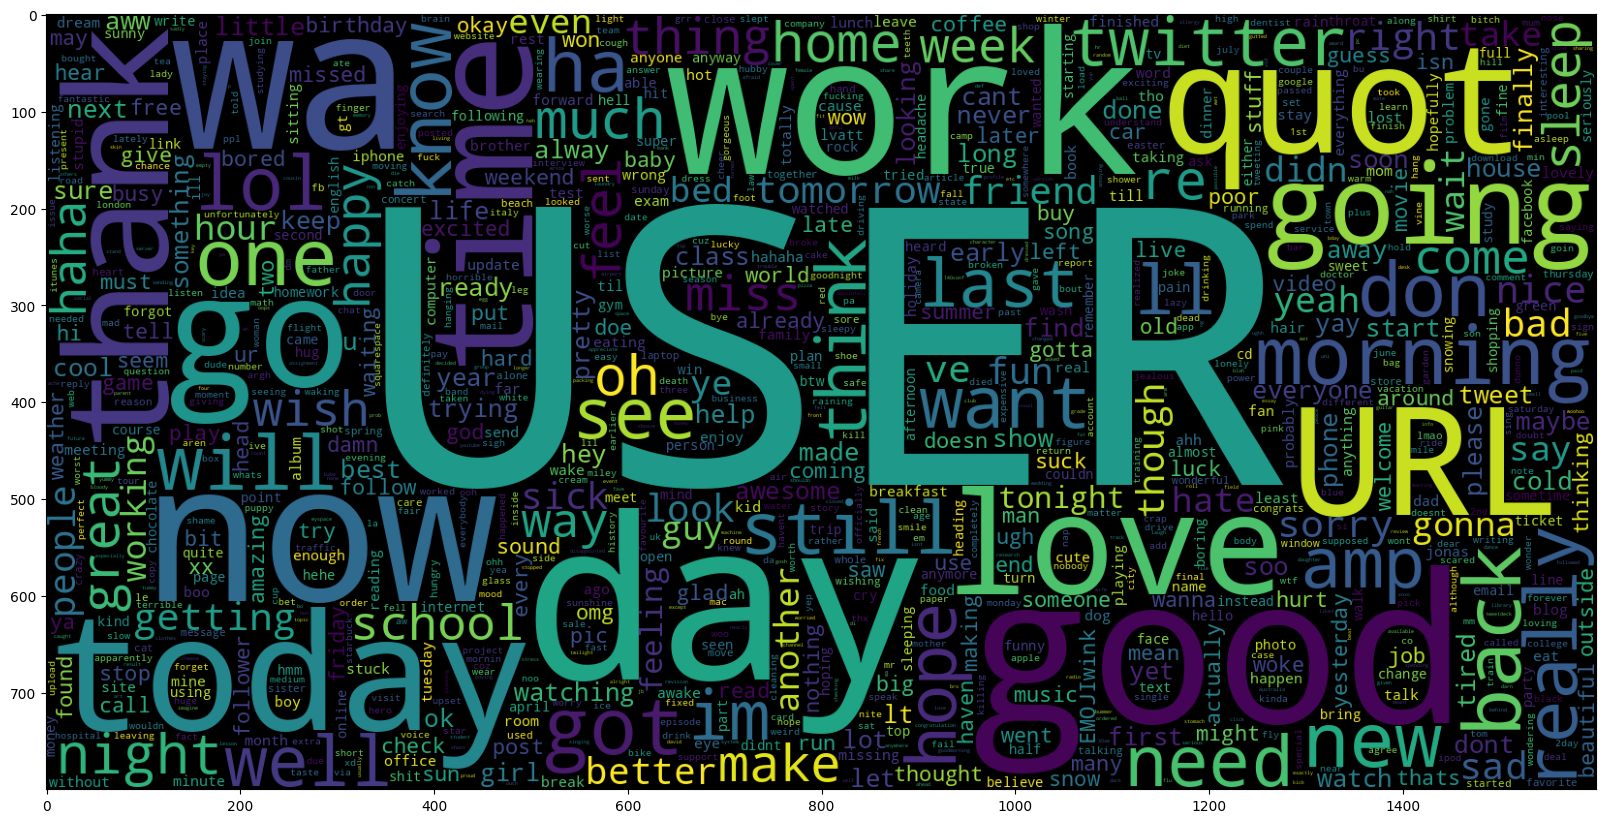

In [82]:
data_pos = processedtext[1000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [84]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  2000


In [85]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [87]:
def model_Evaluate(model):

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)


              precision    recall  f1-score   support

           0       0.74      0.76      0.75       494
           1       0.76      0.74      0.75       506

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



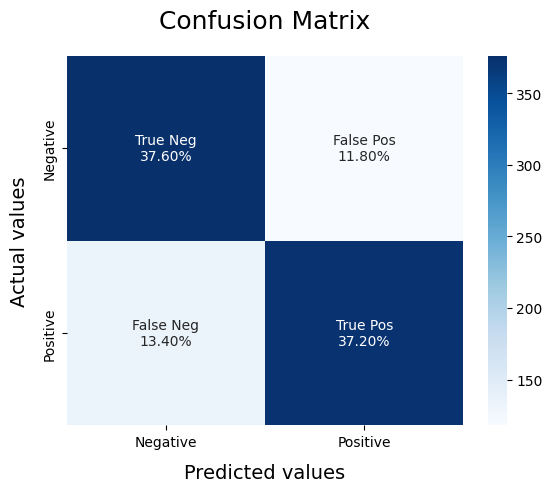

In [88]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       494
           1       0.78      0.77      0.77       506

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



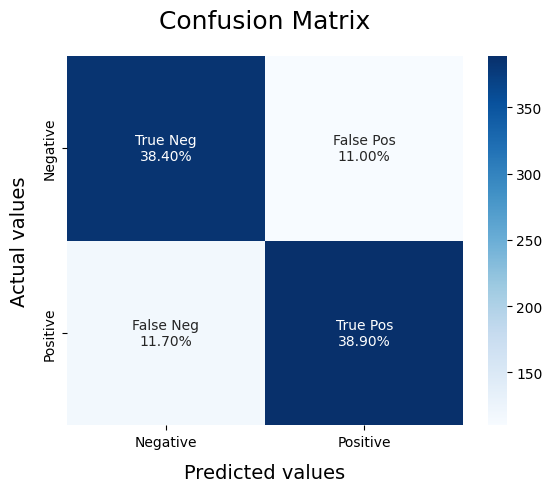

In [89]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       494
           1       0.78      0.77      0.77       506

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



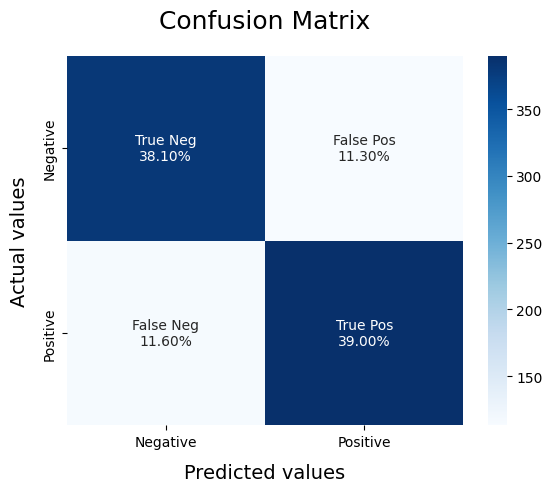

In [90]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [91]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [95]:
def load_models():

    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()

    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel

def predict(vectoriser, model, text):

    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    df = pd.DataFrame(data, columns=['text', 'sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":

    text = ["I hate twitter",
            "I can do this all day.",
            "Mr. Stark, I don't feel so good"]

    df = predict(vectoriser, LRmodel, text)
    print(df.head())


                              text sentiment
0                   I hate twitter  Negative
1           I can do this all day.  Negative
2  Mr. Stark, I don't feel so good  Positive
